In [1]:
import chromadb
import numpy as np
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage, BaseMessage
from langchain_core.tools import tool
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import InMemorySaver

from utils.reranking import ReRanking

from IPython.display import display, Image
import dotenv

In [2]:
dotenv.load_dotenv()

True

In [3]:
with open('prompts/assistant.md') as f:
    system_prompt = f.read()
with open('prompts/expand_query.md') as f:
    expand_query_prompt = f.read()

In [4]:
class State(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [5]:
client = chromadb.PersistentClient()
embedding = SentenceTransformerEmbeddingFunction()
collection = client.get_collection('prompt_engineering_knowledge', embedding_function=embedding)

In [6]:
re_ranker = ReRanking()

In [8]:
expander_llm = ChatOpenAI(
    model='gpt-3.5-turbo',
    temperature=0.7
)

In [9]:
def expand(query) -> list[str]:
    system = SystemMessage(
        content=expand_query_prompt
    )
    user = HumanMessage(content=f"Create five questions from: {query}")
    result = expander_llm.invoke([
        system,
        user
    ])

    return [q.strip() for q in result.content.split('\n\n')]   

In [7]:
@tool()
def knowledge_tool(query: str):
    """ Consult prompt engineering knowledge

    Args:
        query: User request
    """
    queries = expand(query)
    results = collection.query(query_texts=queries, n_results=10)

    retrieved_documents = set()
    for documents in results['documents']:
        for document in documents:
            retrieved_documents.add(document)

    reranked_documents = re_ranker.rerank(query, list(retrieved_documents))

    top_five = reranked_documents[:5]

    return '\n\n'.join([r[0] for r in top_five])

In [10]:
llm = ChatOpenAI(
    model='gpt-4o-mini',
    temperature=0.0
)
tools = [knowledge_tool]
chat_llm = llm.bind_tools(tools=tools)

In [11]:
def assistant(state: State):
    system = SystemMessage(
        content=system_prompt
    )

    return {"messages": [chat_llm.invoke([system] + state['messages'])]}

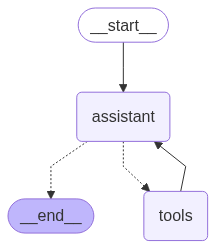

In [12]:
graph = StateGraph(State)

graph.add_node('assistant', assistant)
graph.add_node('tools', ToolNode(tools))

graph.add_edge(START, 'assistant')
graph.add_conditional_edges(
    'assistant',
    tools_condition
)
graph.add_edge('tools', 'assistant')

checkpointer = InMemorySaver()
agent = graph.compile(checkpointer=checkpointer)

display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

In [13]:
query = 'Wha are the main differences between prompt engineering and prompt design?'
config = {'thread_id': "1"}

messages = [
    HumanMessage(content=query)
]
response = agent.invoke({"messages": messages}, {'configurable': config})
for m in response['messages']:
    m.pretty_print()

================================ Human Message =================================

Wha are the main differences between prompt engineering and prompt design?
================================== Ai Message ==================================
Tool Calls:
  knowledge_tool (call_PWvtmqJ2DvbNeeBaU8DrZFJn)
 Call ID: call_PWvtmqJ2DvbNeeBaU8DrZFJn
  Args:
    query: differences between prompt engineering and prompt design
================================= Tool Message =================================
Name: knowledge_tool

when designing prompts, start simple and iterate to achieve optimal results, using platforms like openai or cohere for experimentation. use clear instructions such as " write ", " classify ", or " translate " at the beginning of your prompts, and consider separating instructions from context with a clear separator like " # # # ". specificity is crucial ; detailed prompts yield better results, and including relevant examples can enhance output quality. avoid impreciseness by bei